#Initialization of the kaggle and the files#

In [1]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# install Kaggle
! pip install kaggle

Log into your Kaggle account, go to Account > API > Create new API token. You will obtain a kaggle.json file, which you save on your Google Drive directy in my drive.

In [3]:
!mkdir ~/.kaggle

In [4]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [5]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

100% 303k/303k [00:00<00:00, 558kB/s]
100% 303k/303k [00:00<00:00, 557kB/s]


# Begining of the model
#####We install the transformers and spacy that we'll use later for

In [6]:
!pip install -q transformers
!python -m spacy download fr_core_news_sm


2023-11-30 15:36:08.813879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 15:36:08.813945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 15:36:08.813978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 15:36:08.823593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 15:36:10.153044: W tensorflow/compiler/

## Imports##

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import multiprocessing
import string

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix

df = pd.read_csv('training_data.csv', index_col = 'id')
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')

#####We use spacy to treat the french language for the tokeninzation and treatment of our sentences like for the stop words


In [14]:
sp =spacy.load('fr_core_news_sm')
sp_EN = spacy.load('en_core_web_sm')

In [9]:
df

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


In [10]:
X=df['sentence']
y=df['difficulty']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#####As we said in the first model of Tfidf, here we decide to keep the stop words to see the difference and if how much the french stop words have an impact in the prediction

In [12]:
def spacy_tokenizer(sentence):


    mytokens = sp(sentence)

    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    return mytokens

##### As we can see there is a big difference between the stop words in french and in english. There is 181 more stop words in french than in french

In [15]:
stop_words_FR = spacy.lang.fr.stop_words.STOP_WORDS
stop_words_EN=spacy.lang.en.stop_words.STOP_WORDS
print(stop_words_FR)
print("Number of stopwords in French: "+str(len(stop_words_FR)))
print(stop_words_EN)
print("Number of stopwords in English: "+str(len(stop_words_EN)))


{'parmi', 'delà', 'cela', 'dite', 'tout', 'quatre-vingt', 'tels', 'differentes', 'mille', 'dire', 'j’', 'gens', 'pas', 'quant-à-soi', "quelqu'un", 'possibles', 'sinon', 'derrière', 'dehors', 'compris', 'dessous', 'i', 'ainsi', 'effet', 'ô', 'elles-memes', 'treize', 'etre', 'quant', 'lors', 'notamment', 'cinquantaine', 'seule', 'très', 'celle-la', 'sauf', 'quinze', 'celles-là', 'comment', 'unes', 'vous', 'etaient', 'chacune', 'dans', 'certaines', 'fait', 'que', 'revoici', 'différent', 'quelque', 'parler', 'te', 'or', 'sa', 'plus', 'toi', 'sous', 'neanmoins', 'tres', 'precisement', 'sans', 'hormis', 'cinquantième', 'elles-mêmes', "qu'", 'celle', 'different', 'voici', 'desquelles', 'revoilà', 'hue', 'celles', 'etait', 'quelle', 'ceux-là', 'etc', 'cet', 'un', 'quelles', 'té', 'toujours', 'également', 'douzième', 'déjà', 'notre', 'certes', 'suit', 'ne', 'relativement', 'cinquième', 'voila', 'moi', 'â', 'moindres', 'jusque', 'ces', 'nôtre', 'font', 'concernant', 'allons', 'cette', 'pouvait',

#####Here we create our classifier and our pipeline who will be use to train our model and see how our model is near of the true label

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='UTF-8', min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7bbc87a3d510>)),
                ('classifier', LogisticRegression(max_iter=1000))])

#####We predict the sentences of our true label to see how far we are from the true difficulty level label

In [17]:
y_pred = pipe.predict(X_test)

In [18]:
y_pred

array(['A1', 'C1', 'C2', 'B2', 'B1', 'C1', 'A1', 'A2', 'A2', 'B2', 'A1',
       'A2', 'B2', 'B2', 'C2', 'C2', 'B1', 'C2', 'A1', 'A1', 'B1', 'C1',
       'A2', 'C1', 'A1', 'B1', 'A2', 'A2', 'C2', 'A1', 'B2', 'B2', 'B1',
       'B1', 'A2', 'B2', 'A2', 'B2', 'C1', 'A2', 'C2', 'C2', 'C2', 'A2',
       'C2', 'B1', 'A1', 'B2', 'B2', 'C1', 'C1', 'A2', 'C2', 'A1', 'C1',
       'A2', 'B2', 'C2', 'A2', 'B1', 'C1', 'C2', 'A1', 'C2', 'C1', 'C1',
       'A1', 'A2', 'C1', 'B1', 'C2', 'B2', 'A2', 'B2', 'A2', 'C2', 'A1',
       'A1', 'A1', 'A1', 'A2', 'B2', 'C1', 'C2', 'C1', 'A1', 'A2', 'C2',
       'A1', 'A1', 'C2', 'C2', 'C1', 'A1', 'B1', 'B1', 'A2', 'A2', 'B1',
       'B2', 'C2', 'C2', 'C2', 'A1', 'A2', 'A1', 'B1', 'C1', 'B1', 'C2',
       'C1', 'A2', 'A2', 'A1', 'C1', 'A2', 'C1', 'B2', 'B1', 'A1', 'A1',
       'A1', 'B1', 'C2', 'B2', 'A2', 'C1', 'B2', 'A1', 'B1', 'C1', 'C1',
       'A1', 'A1', 'A1', 'C2', 'C1', 'A2', 'A1', 'C2', 'A2', 'B2', 'B1',
       'B2', 'A1', 'A2', 'C2', 'A2', 'A2', 'C1', 'B

######Then we calculate different metrics to some figures to see how good is our model. And we can see a big improvment by not removing the french stop words.

In [19]:
accuracy_tfidf = round(accuracy_score(y_test, y_pred), 4)
precision_tfidf = round(precision_score(y_test, y_pred, average='macro'),4)
recall_tfidf = round(recall_score(y_test, y_pred, average='macro'),4)
f1_tfidf = round(f1_score(y_test, y_pred, average='macro'),4)
print(f'The accuracy using TF-IDF is: {accuracy_tfidf}')
print(f'The precision using TF-IDF is: {precision_tfidf}')
print(f'The recall using TF-IDF is: {recall_tfidf}')
print(f'The f1 score using TF-IDF is: {f1_tfidf}')

The accuracy using TF-IDF is: 0.4719
The precision using TF-IDF is: 0.4666
The recall using TF-IDF is: 0.4712
The f1 score using TF-IDF is: 0.4666


#####And now we will see the confusion matrix of our model

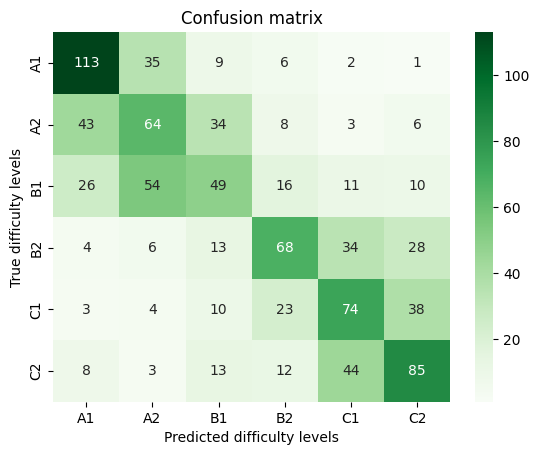

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
difficulty_labels=["A1","A2","B1","B2","C1","C2"]
sns.heatmap(conf_matrix, annot=True, fmt='g',xticklabels=difficulty_labels,yticklabels=difficulty_labels,cmap="Greens")
plt.xlabel('Predicted difficulty levels')
plt.ylabel('True difficulty levels')
plt.title('Confusion matrix')
plt.show()

##Prediction

In [21]:
df_pred

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...
1195,C'est un phénomène qui trouve une accélération...
1196,Je vais parler au serveur et voir si on peut d...
1197,Il n'était pas comme tant de gens qui par pare...


In [22]:
df_pred['predicted_difficulty'] = pipe.predict(df_pred['sentence'])

In [23]:
df_pred

,sentence,predicted_difficulty
id,,
0,Nous dûmes nous excuser des propos que nous eû...,A2
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,A2
2,"Et, paradoxalement, boire froid n'est pas la b...",B1
3,"Ce n'est pas étonnant, car c'est une saison my...",B1
4,"Le corps de Golo lui-même, d'une essence aussi...",C2
...,...,...
1195,C'est un phénomène qui trouve une accélération...,B1
1196,Je vais parler au serveur et voir si on peut d...,A2
1197,Il n'était pas comme tant de gens qui par pare...,C2


# This is how to submit a pd file with predictions
### for the example we will submit a file where only A1 is given as a prediction

In [24]:
df_sub=df_pred[['predicted_difficulty']]
df_sub.to_csv('submission.csv')

In [25]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.31k/8.31k [00:02<00:00, 3.78kB/s]
Successfully submitted to Detecting the difficulty level of French texts

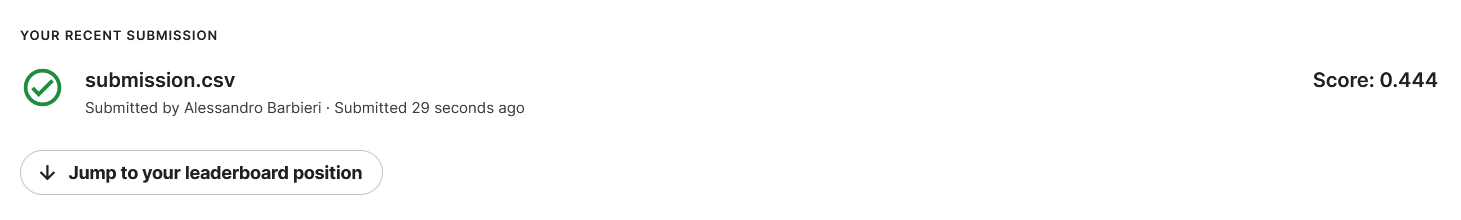